# Input dataset

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet101
from keras import optimizers
from keras.models import Model

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np

# Experiment settings
train_data_path = '/root/data/imagenette_ours_50/train/'
val_data_path = '/root/data/imagenette_ours_50/val'
batch_size = 100
number_of_classes = 10
target_size = (224, 224)

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True # set True to train the model from scratch
    )

Found 9972 images belonging to 10 classes.


In [3]:
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    val_data_path, # your data here
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True # set True to train the model from scratch
    )

Found 3925 images belonging to 10 classes.


# Train from scratch

In [4]:
model = ResNet101(weights=None,
                 include_top=True,
                 input_shape=(224, 224, 3),
                 classes=number_of_classes)

2023-11-13 18:40:26.961890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:65:03.0, compute capability: 7.0


In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),  
              metrics=['acc'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples / batch_size,  # steps = total samples / batch size
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

In [10]:
model.save('./model/resnet101_ours_50.h5')

/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Using pretrained model

In [8]:
from tensorflow.keras.models import load_model
# Load the model
model = load_model('./model/resnet101_ours_50.h5')

In [9]:
# Use the Global Pooling layer for final features
model.layers[-2]

# Extracting final features

In [10]:
original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(
    '/root/data/imagenette/train/',
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False) # set false here

Found 9471 images belonging to 10 classes.


In [11]:
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_extractor.predict(original_generator)

190/190 [==============================] - 45s 222ms/step


In [13]:
dis_datagen = ImageDataGenerator(rescale=1./255)
distilled_generator = dis_datagen.flow_from_directory(
    '/root/data/Ours_v2_50ipc/',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False) # set false here

distilled_features = feature_extractor.predict(distilled_generator)

Found 500 images belonging to 10 classes.
5/5 [==============================] - 2s 318ms/step


# Visualization

In [14]:
# Using t-sne method
tsne = TSNE(random_state=40, n_components=2,verbose=0, perplexity=30)
train_features_2d = tsne.fit_transform(train_features)

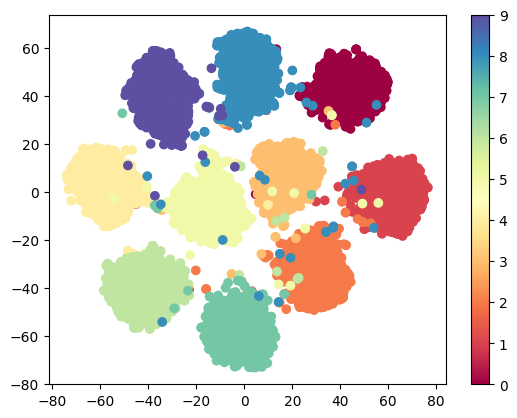

In [15]:
# Get the plot with original dataset
train_labels = original_generator.classes

plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=train_labels, cmap='Spectral')
plt.colorbar()
plt.show()

In [16]:
# Get the plot with both the original and the synthetic dataset
labels = np.concatenate((original_generator.classes, distilled_generator.classes))
features = np.concatenate((train_features,distilled_features))

tsne = TSNE(random_state=40, n_components=2,verbose=0, perplexity=30)
features_2d = tsne.fit_transform(features)

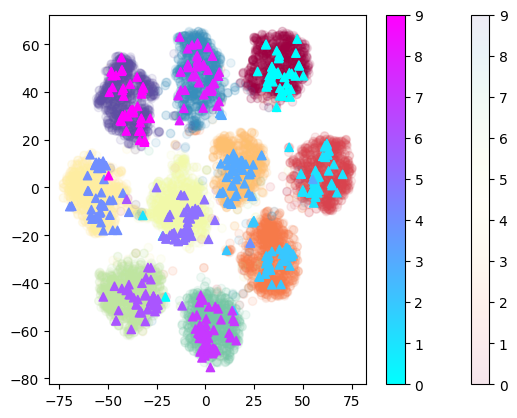

In [17]:
original_features_2d = features_2d[:len(train_features)]
distilled_features_2d = features_2d[len(train_features):]
original_labels = labels[:len(train_features)]
distilled_labels = labels[len(train_features):]

fig, ax = plt.subplots()
scatter1 = ax.scatter(original_features_2d[:, 0], original_features_2d[:, 1], cmap='Spectral', c=original_labels, alpha=0.1)
plt.colorbar(scatter1, ax=ax)

scatter2 = ax.scatter(distilled_features_2d[:, 0], distilled_features_2d[:, 1], cmap='cool', c=distilled_labels, marker='^')
plt.colorbar(scatter2, ax=ax)
plt.show()